##  view the infomation of fits file we use

In [1]:
from astropy.io import fits

vac0 = fits.open('/root/cosmos/galaxies-mzr/data/manga_firefly-v2_4_3-STELLARPOP.fits') 
vac0.info()    # 查看fits文件信息

Filename: /root/cosmos/galaxies-mzr/data/manga_firefly-v2_4_3-STELLARPOP.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  GALAXY_INFO    1 BinTableHDU     31   4675R x 11C   [20A, 20A, I, 20A, E, E, E, E, 20A, 20A, 20A]   
  2  GLOBAL_PARAMETERS    1 BinTableHDU     41   4675R x 16C   [E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E]   
  3  GRADIENT_PARAMETERS    1 BinTableHDU     41   4675R x 16C   [E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E]   
  4  SPATIAL_INFO    1 ImageHDU         9   (4, 2800, 4675)   float32   
  5  SPATIAL_BINID    1 ImageHDU         9   (76, 76, 4675)   int16   
  6  LW_AGE_VORONOI    1 ImageHDU         9   (2, 2800, 4675)   float32   
  7  MW_AGE_VORONOI    1 ImageHDU         9   (2, 2800, 4675)   float32   
  8  LW_Z_VORONOI    1 ImageHDU         9   (2, 2800, 4675)   float32   
  9  MW_Z_VORONOI    1 ImageHDU         9   (2, 2800, 4675)   float32   
 10  E(B_V)_VORONOI    1 ImageH

> ##  1. read data from the file    
> ##  2. calculate the metallicity using the formula from the paper   
> ##  3. use Marvin to calculate the mask   
> ##  4. plot the unmasked surface mass density   
> ##  5. plot the masked surface mass density   
> ## PS. only need to change the parameter of the plate_ifu and prop

In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from astropy.io import fits
import copy

#read in the vac file
vac0 = fits.open('/root/cosmos/galaxies-mzr/data/manga_firefly-v2_4_3-STELLARPOP.fits') 
vac = copy.copy(vac0)    # 去除只读属性

#plate and ifu ID of the galaxy
# such as 9883-3701
plate = 9883
ifu = 3701

#choose the quantity to make the map, could be changed to other properties for which the extension names are listed in the data model  
prop = 'SURFACE_MASS_DENSITY_VORONOI'    # property 特性，根据上面的info来填写即可
#SURFACE_MASS_DENSITY_VORONOI

binid = vac[5].data
basic = vac[1].data
galid = (basic['plate']==plate)&(basic['ifudsgn']==str(ifu))    # 星系编号 galaxy ID
mass = vac[prop].data[galid,:,0][0]    # 获取质量密度数据
bin1d = vac[4].data[galid,:,0][0]    # 获取一维的bin数据

# 导入Marvin的mask
import numpy as np
from matplotlib.colors import ListedColormap
from marvin.tools import Maps
import marvin.utils.plot.map as mapplot

# 获取数据
new_maps = Maps(''.join([str(plate),'-',str(ifu)]))    # 通过Marvin导入星系数据
ha = new_maps.emline_gflux_ha_6564    # 获取Hα
nii = new_maps.emline_gflux_nii_6585    # 获取Nii
oii7 = new_maps.emline_gflux_oii_3727    # 获取O
oii9 = new_maps.emline_gflux_oii_3729    # 获取O

# 计算金属丰度
RR = (oii7+oii9) / nii    # Oii/Nii
# 论文中的关系式【LJ Kewley, MA Dopita 2002】【https://arxiv.org/pdf/astro-ph/0206495】
logRR = np.log10(1.26602*RR+0.167977*RR*RR+1.54020)
oh =  logRR + 8.93
# 计算mask
masks_bpt, __, __ = new_maps.get_bpt()    # 使用bpt图筛选star-forming区域
masks_bpt['sf']['global']
#RR.pixmask.schema    # 查看mask的种类列表
mask_non_sf = ~masks_bpt['sf']['global'] * RR.pixmask.labels_to_value('DONOTUSE')
mask_bad_data = RR.pixmask.get_mask(['NOCOV', 'UNRELIABLE', 'DONOTUSE'])
min_snr = 3.
mask_nii_low_snr = (np.abs(nii.value * np.sqrt(nii.ivar)) < min_snr)
mask_oii7_low_snr = (np.abs(ha.value * np.sqrt(oii7.ivar)) < min_snr)
mask_oii9_low_snr = (np.abs(ha.value * np.sqrt(oii9.ivar)) < min_snr)
new_mask = mask_non_sf | mask_bad_data | mask_nii_low_snr | mask_oii7_low_snr | mask_oii9_low_snr


INFO: No release version set. Setting default to DR15


/root/anaconda3/lib/python3.7/site-packages/marvin/tools/quantities/map.py:400: RuntimeWarning: divide by zero encountered in true_divide
  return 1. / ((1. / ivar1 + 1. / ivar2))
/root/anaconda3/lib/python3.7/site-packages/marvin/tools/quantities/map.py:424: RuntimeWarning: divide by zero encountered in power
  return np.log10(np.e) * ivar**-0.5 / value


<Figure size 850x1000 with 8 Axes>

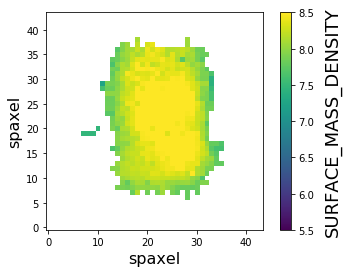

In [3]:
# 画图
image_sz = np.shape(new_mask)[0]    # 图像边长
maps = np.zeros((image_sz,image_sz))-9999    # 初始化画图数组
for i in range(image_sz):
    for j in range(image_sz):
        idbin = (bin1d==binid[galid,i,j])    # 搜索二维bin的值在一维bin数组中的 位置
        if len(bin1d[idbin])==1:    # 挑选出 一维2800的bin和二维76*76的bin相同的数值
            maps[i,j] = mass[idbin]

# 加mask
masked_array = np.ma.array(maps,mask=new_mask)

fig, ax = plt.subplots()
p = ax.imshow(masked_array , origin='lower',vmin=5.5,vmax=8.5)
ax.set_xlabel('spaxel',fontsize=16)
ax.set_ylabel('spaxel',fontsize=16)
cb = fig.colorbar(p)
cb.set_label(prop[0:len(prop)-8],fontsize=18,labelpad=10)
#plt.xlim((0,53))    # x轴坐标范围
#plt.ylim((0,53))    # y轴坐标范围

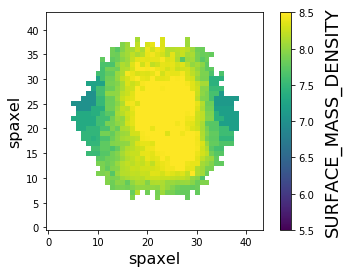

In [4]:
# 不加mask,只去除无效数据
masked_array = np.ma.array(maps,mask=(maps<-666))

fig, ax = plt.subplots()
p = ax.imshow(masked_array , origin='lower',vmin=5.5,vmax=8.5)
ax.set_xlabel('spaxel',fontsize=16)
ax.set_ylabel('spaxel',fontsize=16)
cb = fig.colorbar(p)
cb.set_label(prop[0:len(prop)-8],fontsize=18,labelpad=10)
#plt.xlim((0,53))    # x轴坐标范围
#plt.ylim((0,53))    # y轴坐标范围